In [13]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter
from sklearn.model_selection import train_test_split

### Import Data

In [14]:
df_train = pd.read_csv('/kaggle/input/feature-generation-dataset/train_dataset.csv', low_memory=False)
df_test = pd.read_csv('/kaggle/input/feature-generation-dataset/test_dataset.csv', low_memory=False)

In [15]:
df_train.shape, df_test.shape

((1296675, 43), (555719, 43))

In [16]:
features = ['amt', 'gender_numeric', 'city_pop','cc_count', 'address_multiple_customer_flag', 'fraud_likelihood_merchant', 'fraud_likelihood_category',
            'Latlong_distance','transaction_distance', 'fraud_likelihood_job', 'fraud_likelihood_age', 'address_multiple_card_flag', 'multiple_cards_large_orders',
            'large_order','first_time_shopper', 'is_fraud']

def clean_df(df):
      # Retain only the columns specified in features
    df_cleaned = df[features].copy()
    return df_cleaned

train_df = clean_df(df_train)
test_df = clean_df(df_test)

### Checking if test dataset is 20% of the entire datasets and forming the train test accordingly (no sampling)

In [17]:
# Placeholder for the target variable name
target_var = 'is_fraud'

# Assess Current Distribution of datasets
total_size = len(train_df) + len(test_df)
current_test_percentage = (len(test_df) / total_size) * 100
print(f"Current test set percentage: {current_test_percentage}%")

Current test set percentage: 30.000043187356468%


In [18]:
# Resize the Test Set with Stratified Sampling (If Necessary)
if current_test_percentage > 20:
    # Calculate the desired number of test samples to represent approximately 20% of the total data
    desired_test_size = int(total_size * 0.2)

    # Separate features and target variable for stratification
    X_test = test_df.drop(columns=[target_var])
    Y_test = test_df[target_var]

    # Use train_test_split to stratify and reduce the size of the test dataset
    _, x_test, _, y_test = train_test_split(X_test, Y_test, train_size=desired_test_size, stratify=Y_test, random_state=42)

    # Combine the features and target variable back into a downsized test dataframe
    test_df_downsampled = pd.concat([x_test, y_test], axis=1)
else:
    test_df_downsampled = test_df

In [19]:
# Split the Training Data to Create a Validation Set with Stratified Sampling
# Calculate the new ratio for the validation set, given the adjusted test set
remaining_data_size = total_size - len(test_df_downsampled)
validation_ratio = (0.1 * total_size) / remaining_data_size

# Separate features and target variable in the training data for stratification
X_train = train_df.drop(columns=[target_var])
Y_train = train_df[target_var]

# Split the training data to create a validation set, using stratified sampling
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=validation_ratio, stratify=Y_train, random_state=42)

# Combine the features and target variable back into training and validation dataframes
train_df_split = pd.concat([x_train, y_train], axis=1)
val_df_split = pd.concat([x_val, y_val], axis=1)

### Models

### Models with SMOTE (Synthetic Minority Oversampling Technique)

In [20]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, roc_curve, precision_score, recall_score, classification_report
import numpy as np

In [21]:
def model_train_and_evaluate_with_smote(estimator, x_train, y_train, x_test, y_test):
    """
    Train a model with SMOTE and evaluate it, returning performance metrics including F2, Precision, and Recall.
    """
    # Create a pipeline with SMOTE and the estimator
    pipeline = make_pipeline(SMOTE(random_state=42), estimator)

    # Fit the pipeline
    pipeline.fit(x_train, y_train)

    # Predict on the test set
    y_pred = pipeline.predict(x_test)
    y_pred_proba = pipeline.predict_proba(x_test)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')  # F2 score
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')

    # ROC curve metrics
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    print(f'\nModel with SMOTE: {estimator.__class__.__name__}')
    print('Accuracy:', accuracy)  # Display accuracy
    print('F1 Score:', f1)
    print('F2 Score:', f2)  # Added F2 Score
    print('Precision:', precision)  # Added Precision
    print('Recall:', recall)  # Added Recall
    print('AUC Score:', auc)
    print(classification_report(y_test, y_pred))

    return f1, f2, auc, accuracy, precision, recall, fpr, tpr

### Best Model with tuned hyperparameters

In [22]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [23]:
# random forest hyperparam tune train and test
from sklearn.model_selection import RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score, recall_score, classification_report
from scipy.stats import randint

# Function to perform hyperparameter tuning, final training, and evaluation
def model_train_evaluate_tune_random_search(estimator, search_spaces, x_train_full, y_train_full, x_test, y_test, scoring_metric, n_iter=100, verbose=10):
    # First, sample a subset of the training data for hyperparameter tuning
    x_train_sampled, _, y_train_sampled, _ = train_test_split(
        x_train_full, y_train_full,
        stratify=y_train_full,
        test_size=0.95,  # Adjust as needed
        random_state=42
    )

    # Perform hyperparameter tuning on the sampled data
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=search_spaces,
        n_iter=n_iter,
        scoring=scoring_metric,
        cv=5,
        n_jobs=-1,
        verbose=verbose,
        random_state=42,
        return_train_score=True
    )

    # Fit RandomizedSearchCV on the sampled dataset
    random_search.fit(x_train_sampled, y_train_sampled)

    # Retrieve the best hyperparameters from the tuning process
    best_hyperparams = random_search.best_params_

    # Create a new model instance with the best hyperparameters for final training on the full training dataset
    final_estimator = ImbPipeline([
        ('smote', SMOTE(random_state=42)),
        ('randomforestclassifier', RandomForestClassifier(
            random_state=13,
            n_estimators=best_hyperparams['randomforestclassifier__n_estimators'],
            max_features=best_hyperparams['randomforestclassifier__max_features'],
            max_depth=best_hyperparams['randomforestclassifier__max_depth'],
            min_samples_split=best_hyperparams['randomforestclassifier__min_samples_split'],
            min_samples_leaf=best_hyperparams['randomforestclassifier__min_samples_leaf'],
        ))
    ])

    # Fit the final model on the full training data
    final_estimator.fit(x_train_full, y_train_full)

    # Predict on the test set with the final model
    y_pred = final_estimator.predict(x_test)
    y_pred_proba = final_estimator.predict_proba(x_test)[:, 1] if hasattr(final_estimator, "predict_proba") else final_estimator.decision_function(x_test)

    # Calculate and print final evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)


    print("\nFinal Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(classification_report(y_test, y_pred))

    # Return metrics for both tuning and final evaluation
    return {
        'tuning_best_params': best_hyperparams,
        'name' : 'Tuned Random Forest',
        'f1': f1,
        'f2': f2,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
    }



In [24]:
# Adjusted pipeline using imblearn's Pipeline
pipeline_smote_rf = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('randomforestclassifier', RandomForestClassifier(random_state=13))
])

# Define your search spaces as before
search_spaces_rf = {
    'randomforestclassifier__n_estimators': randint(50, 150),
    'randomforestclassifier__max_features': ['auto', 'sqrt', 'log2'],
    'randomforestclassifier__max_depth': [None, 10, 20, 30],
    'randomforestclassifier__min_samples_split': randint(2, 10),
    'randomforestclassifier__min_samples_leaf': randint(1, 4),
}

# Assuming definitions of x_train_full, y_train_full, x_test, y_test, and search_spaces_rf are provided elsewhere
rf_tuned_model_metrics = model_train_evaluate_tune_random_search(
    estimator=pipeline_smote_rf,
    search_spaces=search_spaces_rf,
    x_train_full=x_train,
    y_train_full=y_train,
    x_test=x_test,
    y_test=y_test,
    scoring_metric='roc_auc',
    verbose=1
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomFor


Final Model Evaluation Metrics:
Accuracy: 0.9770
F1 Score: 0.1912
F2 Score: 0.3395
AUC Score: 0.9572
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    184526
           1       0.11      0.70      0.19       715

    accuracy                           0.98    185241
   macro avg       0.55      0.84      0.59    185241
weighted avg       1.00      0.98      0.99    185241



In [25]:
# log regression hyperparam tune train and test
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, roc_auc_score, precision_score, recall_score, classification_report, roc_curve
from scipy.stats import loguniform

def model_train_evaluate_tune_random_search(estimator, search_spaces, x_train_full, y_train_full, x_test, y_test, scoring_metric, n_iter=100, verbose=10):
    # First, sample a subset of the training data for hyperparameter tuning
    x_train_sampled, _, y_train_sampled, _ = train_test_split(
        x_train_full, y_train_full,
        stratify=y_train_full,
        test_size=0.95,  # Adjust as needed
        random_state=42
    )
    
    # Perform hyperparameter tuning on the sampled data
    random_search = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=search_spaces,
        n_iter=n_iter,
        scoring=scoring_metric,
        cv=5,
        n_jobs=-1,
        verbose=verbose,
        random_state=42,
        return_train_score=True
    )
    
    # Fit RandomizedSearchCV on the sampled dataset
    random_search.fit(x_train_sampled, y_train_sampled)
    
    # Retrieve the best hyperparameters from the tuning process
    best_hyperparams = random_search.best_params_
    
    # Create a new model instance with the best hyperparameters for final training on the full training dataset
    final_estimator = estimator.set_params(**best_hyperparams)
    
    # Fit the final model on the full training data
    final_estimator.fit(x_train_full, y_train_full)
    
    # Predict on the test set with the final model
    y_pred = final_estimator.predict(x_test)
    y_pred_proba = final_estimator.predict_proba(x_test)[:, 1]  # Logistic Regression supports predict_proba
    
    # Calculate and print final evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='binary')
    f2 = fbeta_score(y_test, y_pred, beta=2, average='binary')
    auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred, average='binary')
    recall = recall_score(y_test, y_pred, average='binary')
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

    print("\nFinal Model Evaluation Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"F2 Score: {f2:.4f}")
    print(f"AUC Score: {auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(classification_report(y_test, y_pred))

    # Return metrics for both tuning and final evaluation
    return {
        'tuning_best_params': best_hyperparams,
        'name': 'Tuned Logistic Regression',
        'f1': f1,
        'f2': f2,
        'auc': auc,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'fpr': fpr,
        'tpr': tpr,
    }




In [26]:
# Adjusted pipeline for Logistic Regression
pipeline_smote_lr = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('logisticregression', LogisticRegression(max_iter=1000, random_state=13))
])

# Define the search space for Logistic Regression
search_spaces_lr = {
    'logisticregression__C': loguniform(1e-5, 100),
    'logisticregression__solver': ['liblinear', 'lbfgs']
}

# Assuming x_train_full, y_train_full, x_test, y_test are defined
lgr_tuned_model_metrics = model_train_evaluate_tune_random_search(
    estimator=pipeline_smote_lr,
    search_spaces=search_spaces_lr,
    x_train_full=x_train,
    y_train_full=y_train,
    x_test=x_test,
    y_test=y_test,
    scoring_metric='roc_auc',
    verbose=1
)

Fitting 5 folds for each of 100 candidates, totalling 500 fits

Final Model Evaluation Metrics:
Accuracy: 0.9005
F1 Score: 0.0546
F2 Score: 0.1230
AUC Score: 0.8453
Precision: 0.0283
Recall: 0.7441
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    184526
           1       0.03      0.74      0.05       715

    accuracy                           0.90    185241
   macro avg       0.51      0.82      0.50    185241
weighted avg       1.00      0.90      0.94    185241



### Simple Fully Connected Neural Network (Multi Layer Perceptron)

In [27]:
from tqdm import tqdm
from sklearn.metrics import f1_score, fbeta_score, roc_auc_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from imblearn.over_sampling import SMOTE


import torch
import numpy as np

In [28]:
batch_size = 64

scaler = StandardScaler()

# Fit on the training data
scaler.fit(x_train)

# Transform training, validation, and test data
x_train_norm = scaler.transform(x_train)
x_val_norm = scaler.transform(x_val)
x_test_norm = scaler.transform(x_test)

# Apply SMOTE to the scaled training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(x_train_norm, y_train)


In [29]:
# Now use the normalized data to create your datasets
train_dataset = TensorDataset(torch.tensor(x_train_norm).float(), torch.tensor(y_train.values).float())
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(x_val_norm).float(), torch.tensor(y_val.values).float())
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

test_dataset = TensorDataset(torch.tensor(x_test_norm).float(), torch.tensor(y_test.values).float())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [30]:
class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(num_features, 128),  # Increased number of neurons
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(128, 256),  # Additional layer with more neurons
            nn.ReLU(),
            nn.BatchNorm1d(256),  # Batch normalization layer
            nn.Dropout(0.5),  # Dropout layer for regularization
            nn.Linear(256, 128),  # Additional layer
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.layers(x)

# Initialize the model
model = MLP(x_train.shape[1])  # num_features = number of features in x_train


In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.BCELoss()
learning_rate = 0.001
optimizer = Adam(model.parameters(), lr=learning_rate)

# Training
def train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        # Wrap train_loader with tqdm for a progress bar
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Training"):
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss = train_loss / len(train_loader.dataset)

        # Validation step
        model.eval()
        val_preds, val_targets = [], []
        # Optionally wrap val_loader with tqdm for a progress bar
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs}, Validating"):
                inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
                outputs = model(inputs)
                val_preds.append(outputs.cpu())
                val_targets.append(labels.cpu())

        val_preds = torch.cat(val_preds)
        val_targets = torch.cat(val_targets)

        # Calculate F1 score on validation set
        f1 = f1_score(val_targets.numpy(), val_preds.numpy().round())
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {train_loss:.4f}, Validation F1: {f1:.4f}')

num_epochs = 10
train_and_validate(model, train_loader, val_loader, optimizer, criterion, num_epochs, device=device)

Epoch 1/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 936.99it/s]


Epoch 1/10, Loss: 0.0226, Validation F1: 0.4628


Epoch 2/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 970.44it/s]


Epoch 2/10, Loss: 0.0202, Validation F1: 0.4017


Epoch 3/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 937.52it/s]


Epoch 3/10, Loss: 0.0196, Validation F1: 0.4202


Epoch 4/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 970.15it/s]


Epoch 4/10, Loss: 0.0195, Validation F1: 0.4910


Epoch 5/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 975.01it/s]


Epoch 5/10, Loss: 0.0191, Validation F1: 0.4846


Epoch 6/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 945.94it/s]


Epoch 6/10, Loss: 0.0191, Validation F1: 0.3361


Epoch 7/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 974.55it/s]


Epoch 7/10, Loss: 0.0187, Validation F1: 0.4105


Epoch 8/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 932.44it/s]


Epoch 8/10, Loss: 0.0186, Validation F1: 0.3528


Epoch 9/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 966.65it/s]


Epoch 9/10, Loss: 0.0185, Validation F1: 0.3594


Epoch 10/10, Validating: 100%|██████████| 2252/2252 [00:02<00:00, 960.62it/s]

Epoch 10/10, Loss: 0.0183, Validation F1: 0.4674


In [32]:
def evaluate_model(model, test_loader, device):
    model.eval()
    test_preds, test_targets = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device).unsqueeze(1)
            outputs = model(inputs)
            test_preds.extend(outputs.cpu().numpy())
            test_targets.extend(labels.cpu().numpy())

    test_preds = np.array(test_preds).flatten()
    test_targets = np.array(test_targets).flatten()

    # Calculate precision and recall for all thresholds
    precision, recall, thresholds = precision_recall_curve(test_targets, test_preds)

    # Calculate F1 scores for all thresholds
    f1_scores = 2 * (precision * recall) / (precision + recall)
    f1_scores = np.nan_to_num(f1_scores)  # Replace nan with 0

    # Find the index of the highest F1 score
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]

    binary_preds = test_preds >= optimal_threshold

    # Use the optimal threshold to calculate precision and recall
    precision_at_optimal_threshold = precision_score(test_targets, binary_preds)
    recall_at_optimal_threshold = recall_score(test_targets, binary_preds)


    # Use the optimal threshold to calculate other metrics
    f1 = f1_score(test_targets, test_preds >= optimal_threshold)
    f2 = fbeta_score(test_targets, test_preds >= optimal_threshold, beta=2)
    auc_score = roc_auc_score(test_targets, test_preds)
    accuracy = accuracy_score(test_targets, binary_preds)  # Calculate accuracy
    fpr, tpr, _ = roc_curve(test_targets, test_preds)

    print(f'Optimal Threshold: {optimal_threshold}')
    print(f'Test F1 Score at Optimal Threshold: {f1}')
    print(f'Test F2 Score at Optimal Threshold: {f2}')
    print(f'Test Accuracy: {accuracy}')  # Display accuracy
    print('Precision:', precision_at_optimal_threshold)  # Added Precision
    print('Recall:', recall_at_optimal_threshold)  # Added Recall
    print(f'Test AUC Score: {auc_score}')

    return {
        'name' : 'Multilayer Perceptron',
        'f1': f1,
        'f2': f2,
        'auc': auc_score,
        'accuracy': accuracy,
        'precision': precision_at_optimal_threshold,
        'recall': recall_at_optimal_threshold,
        'fpr': fpr,
        'tpr': tpr,
    }

MLP_model_metrics = evaluate_model(model, test_loader, device)

Optimal Threshold: 0.26416143774986267
Test F1 Score at Optimal Threshold: 0.49573690621193667
Test F2 Score at Optimal Threshold: 0.5373646686031159
Test Accuracy: 0.9955301472136298
Precision: 0.43905070118662354
Recall: 0.5692307692307692
Test AUC Score: 0.9482219345745353


### Plots and Comparisons

In [33]:
import matplotlib.pyplot as plt
import numpy as np

In [34]:
def plot_comparative_roc_curves(models_metrics, model_names):
    """
    Plots ROC curves for multiple models with unique colors for each model's curve.

    :param models_metrics: List of tuples containing (fpr, tpr, auc_score) for each model.
    :param model_names: List of model names as strings.
    """
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(models_metrics)))  # Unique colors for each model

    for (fpr, tpr, auc_score), name, color in zip(models_metrics, model_names, colors):
        plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.2f})', color=color)

    plt.plot([0, 1], [0, 1], 'k--', label='Baseline (Random Model)')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc='lower right')
    plt.show()


In [35]:
def plot_metric_comparison(model_metrics_list, metric):
    """
    Plot a comparison of the specified metric across all models with unique colors for each model, including
    value labels on top of the bars.

    Parameters:
    - model_metrics_list: List of dictionaries containing metrics for each model.
    - metric: The metric to compare ('f1', 'precision', 'recall', etc.).
    """
    # Extract model names and the specified metric values
    model_names = [model['name'] for model in model_metrics_list]
    metric_values = [model[metric] for model in model_metrics_list]

    # Define a list of colors
    colors = plt.cm.viridis(np.linspace(0, 1, len(model_metrics_list)))

    # Generate the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(model_names, metric_values, color=colors)
    plt.xlabel('Models')
    plt.ylabel(metric.capitalize())
    plt.title(f'Comparison of {metric.capitalize()} Scores Across Models')
    plt.xticks(rotation=45)

    # Adding the text labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, yval, f'{yval:.3g}', va='bottom', ha='center')

    plt.tight_layout()  # Adjust layout to fit labels
    plt.show()


In [36]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, fbeta_score, precision_score, recall_score, roc_auc_score, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline

In [37]:
# Base models
model1 = LogisticRegression()
model2 = RandomForestClassifier()
model3 = DecisionTreeClassifier()
model4 = xgb.XGBClassifier()
model5 = AdaBoostClassifier()

models = [model1, model2, model3, model4, model5]  # Your model instances
model_names = ['Logistic Regression', 'Random Forest', 'Decision Tree', 'XG Boost', 'ADA Boost']
model_metrics_list = []

for model in models:
    f1, f2, auc, accuracy, precision, recall, fpr, tpr = model_train_and_evaluate_with_smote(model, x_train, y_train, x_test, y_test)
    model_metrics_list.append({
        'name': model.__class__.__name__,
        'f1': f1,
        'f2': f2,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'auc': auc,
        'fpr': fpr,
        'tpr': tpr,
    })

# Assume that fpr_MLP, tpr_MLP, auc_MLP, f1_MLP, f2_MLP, precision_MLP, recall_MLP are the metrics for your additional models
model_metrics_list.append(MLP_model_metrics)
model_names.extend('Multilayer Perceptron')
model_metrics_list.append(rf_tuned_model_metrics)
model_names.extend('Tuned Random Forest')
model_metrics_list.append(lgr_tuned_model_metrics)
model_names.extend('Tuned Log Regression')


Model with SMOTE: LogisticRegression
Accuracy: 0.9001408975334834
F1 Score: 0.0543911665473878
F2 Score: 0.12254111576910674
Precision: 0.02822730408022497
Recall: 0.7440559440559441
AUC Score: 0.8453360638472763
              precision    recall  f1-score   support

           0       1.00      0.90      0.95    184526
           1       0.03      0.74      0.05       715

    accuracy                           0.90    185241
   macro avg       0.51      0.82      0.50    185241
weighted avg       1.00      0.90      0.94    185241


Model with SMOTE: RandomForestClassifier
Accuracy: 0.9830221171338959
F1 Score: 0.2221122928518427
F2 Score: 0.3627989657401422
Precision: 0.1349158653846154
Recall: 0.627972027972028
AUC Score: 0.9352043212740351
              precision    recall  f1-score   support

           0       1.00      0.98      0.99    184526
           1       0.13      0.63      0.22       715

    accuracy                           0.98    185241
   macro avg       0.57   

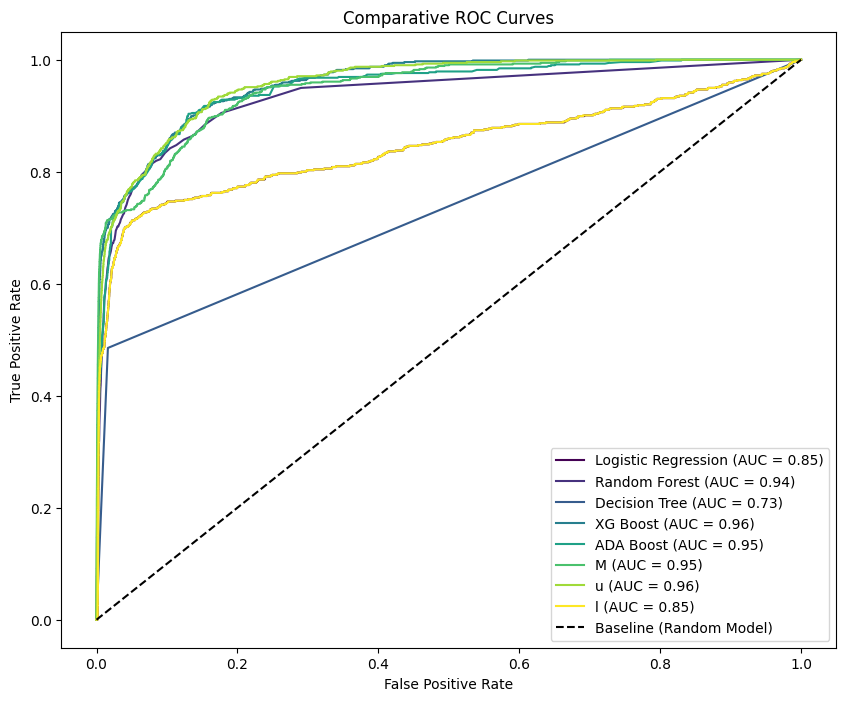

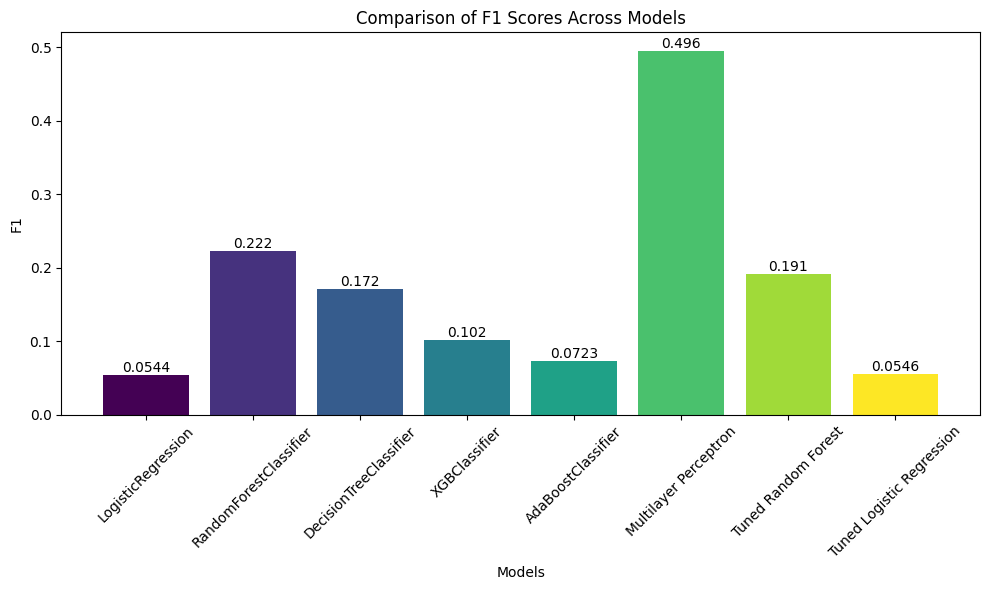

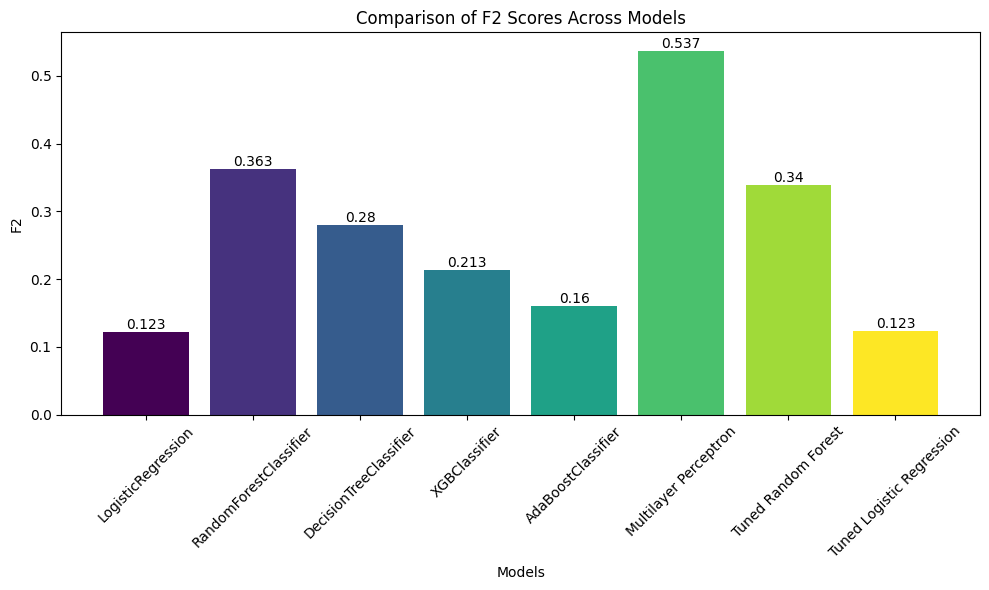

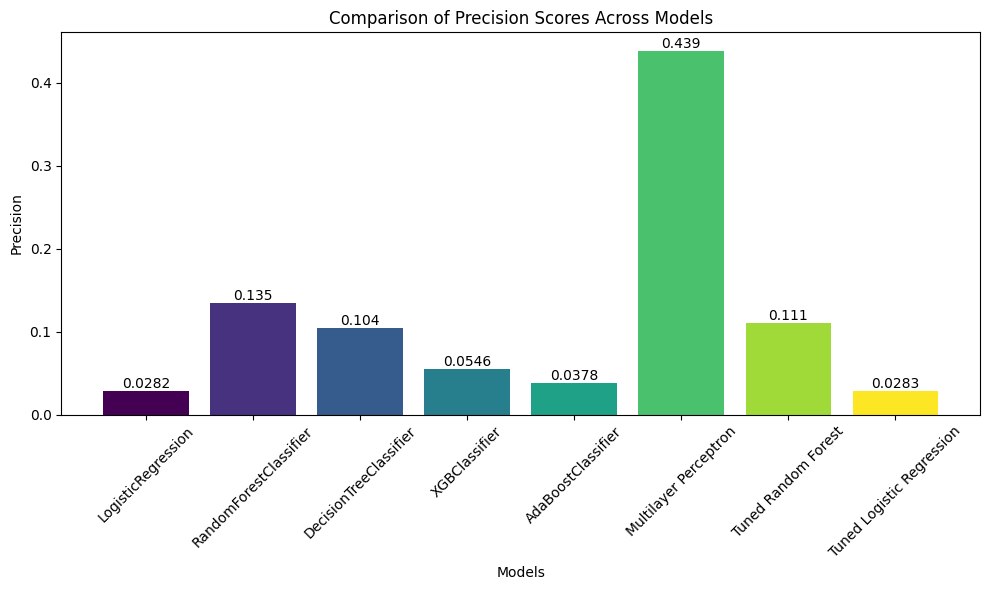

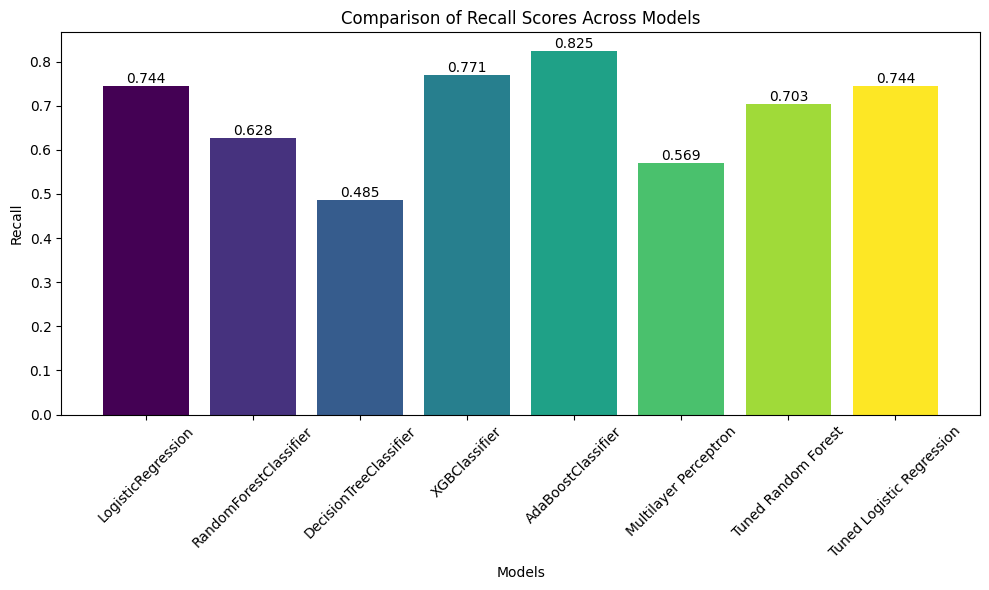

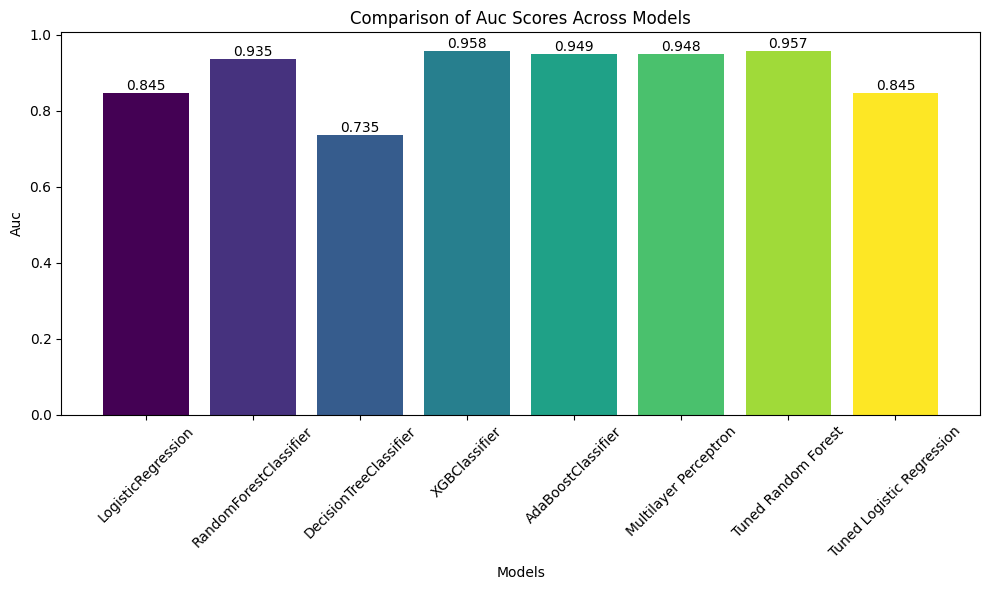

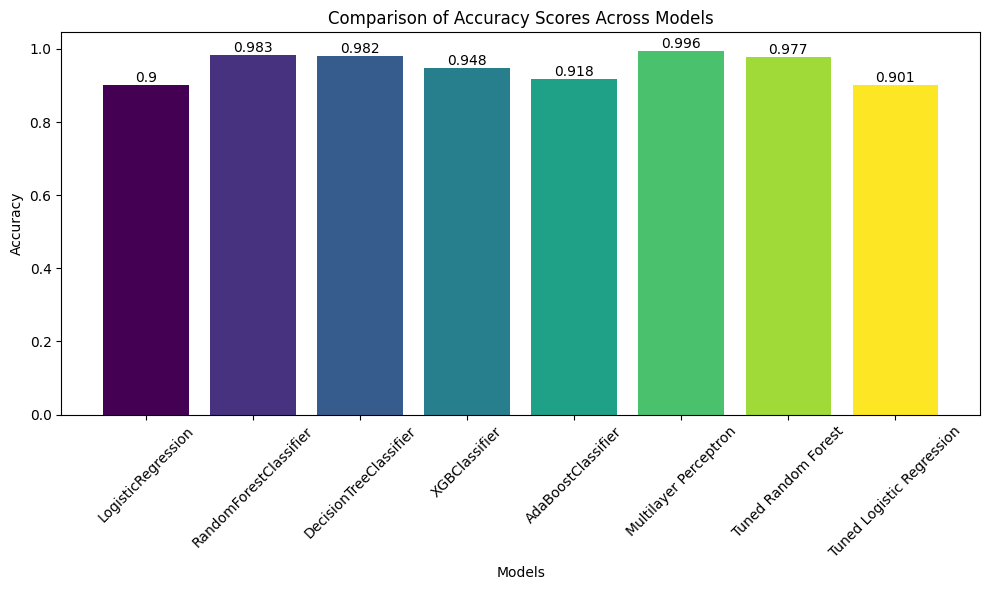

In [38]:
# Now, you can use the collected metrics to plot ROC curves and compare other metrics as well
# Plotting ROC curves
models_roc_metrics = [(m['fpr'], m['tpr'], m['auc']) for m in model_metrics_list]
plot_comparative_roc_curves(models_roc_metrics, model_names)

# # You can also plot the comparison of F1, F2, Precision, and Recall using the new `plot_metric_comparison` function
# for metric in ['f1', 'f2', 'precision', 'recall']:
#     plot_metric_comparison(model_metrics_list, metric)

# You can also plot the comparison of F1, F2, Precision, and Recall using the new `plot_metric_comparison` function
for metric in ['f1', 'f2', 'precision', 'recall', 'auc', 'accuracy']:
    plot_metric_comparison(model_metrics_list, metric)